In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
import glob
import datetime
import warnings
warnings.filterwarnings('ignore')

np.random.seed(7)
from colorama import Fore
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot

### Merging All Zones Data

In [3]:
month_one = pd.read_csv("data/2017-01_1H_zone.csv")
month_two = pd.read_csv("data/2017-02_1H_zone.csv")
month_three = pd.read_csv("data/2017-03_1H_zone.csv")
month_four = pd.read_csv("data/2017-04_1H_zone.csv")
month_five = pd.read_csv("data/2017-05_1H_zone.csv")

all_months = pd.concat([month_one, month_two, month_three, month_four, month_five])
# dropping index column
all_months.drop("Unnamed: 0", axis=1, inplace=True)

# get zone wise different dataset
grouped = all_months.groupby(all_months.PUZone)
dfs = []
for i in range(0,73):
    dfs.append(grouped.get_group(i))
dfs[0].head()

PUZone  Count               PUTime
0         0     91  2017-01-01 00:00:00
73        0    137  2017-01-01 01:00:00
146       0    125  2017-01-01 02:00:00
219       0    161  2017-01-01 03:00:00
292       0    151  2017-01-01 04:00:00

In [4]:
zones_output = pd.merge(dfs[0], dfs[1], on="PUTime")
zones_output.rename(columns = {'Count_x':'Count_0'}, inplace = True)
zones_output.rename(columns = {'Count_y':'Count_1'}, inplace = True)
zones_output.drop("PUZone_x", axis = 1, inplace = True)
zones_output.drop("PUZone_y", axis = 1, inplace = True)

for i in range(2, 73):
    zones_output = pd.merge(dfs[i], zones_output, on="PUTime")
    zones_output.rename(columns = {'Count':'Count_' + str(i)}, inplace = True)
    zones_output.drop("PUZone", axis = 1, inplace = True)

print(dfs[50].head())

     PUZone  Count               PUTime
50       50    279  2017-01-01 00:00:00
123      50    304  2017-01-01 01:00:00
196      50    211  2017-01-01 02:00:00
269      50    202  2017-01-01 03:00:00
342      50    174  2017-01-01 04:00:00


### High Traffic Zones

Text(0.5, 1.0, 'Zone vs count')

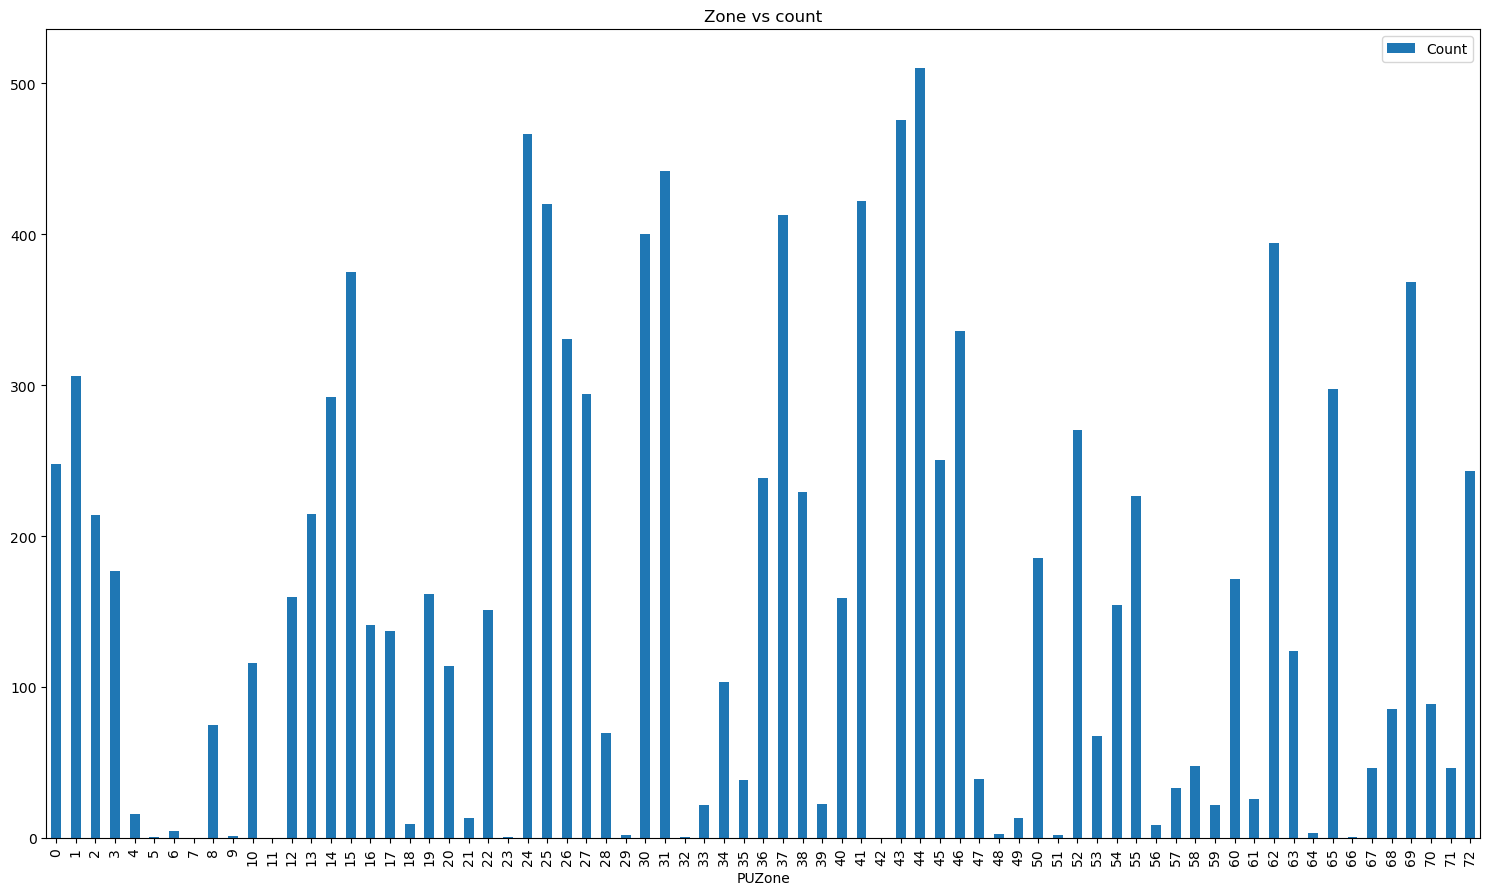

In [5]:
import matplotlib.pyplot as plt
all_months.groupby(["PUZone"]).mean().plot.bar()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.title("Zone vs count")

### Correlation Between Zones

<AxesSubplot:>

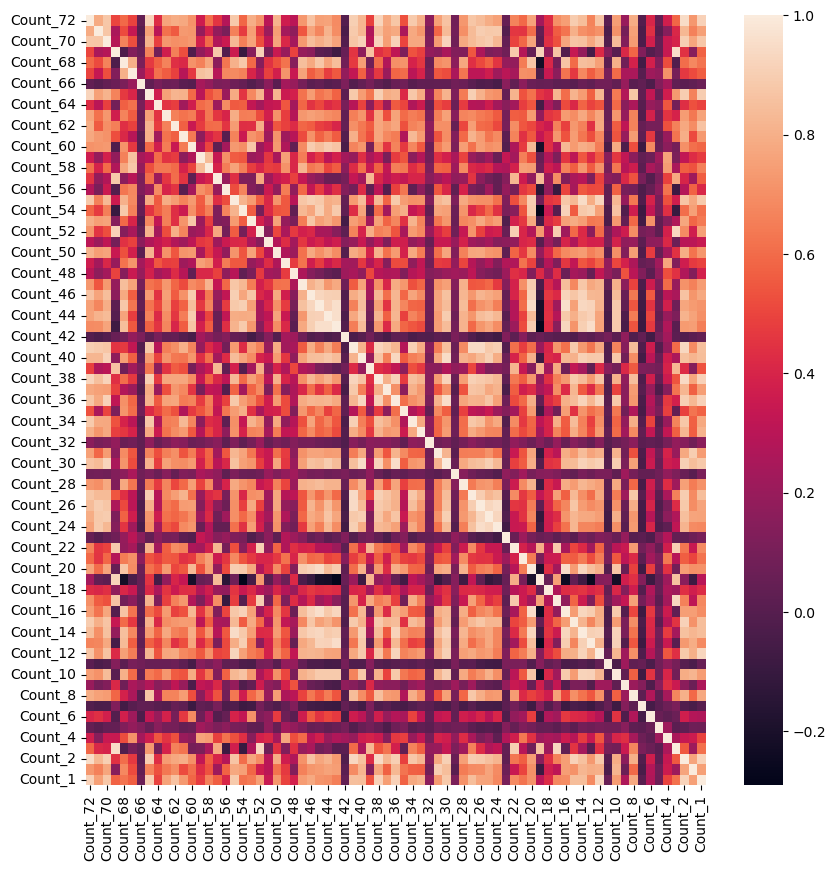

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

#Generating the correlation Matrix
corr = zones_output.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,ax = ax)

Get Zones with correlation over 0.8

In [7]:
#Fill an array with the value True of the size of columns
correlated_zones = {}
for i in range(73):
    correlated_zones[str(i)] = list()

#The matrix is symmetric.. M(i,j) = M(j,i) --> the features are the same for both
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.80:
            correlated_zones[str(i)].append(j)
import json
f = open('data/zone_neighbors.json')
a_json = json.loads(f.read())

lengths = [len(v) for v in a_json.values()]


all_zones = list(range(0, 73))

no_neighbours = [zone for zone in all_zones if str(zone) not in a_json.keys()]
print(no_neighbours) 

[18, 32]


**18 & 32 have no neighbour**

### Intersection between neighbours and maximum correlated zones

In [8]:
intersecting_zones = {}
for i in range(73):
    if str(i) not in a_json:
        intersecting_zones[str(i)] = []
        continue
    intersecting_zones[str(i)] = [zone for zone in correlated_zones[str(i)] if zone in a_json[str(i)]]


print(intersecting_zones)

{'0': [31], '1': [2], '2': [72], '3': [69], '4': [59], '5': [], '6': [], '7': [], '8': [], '9': [], '10': [], '11': [], '12': [], '13': [14], '14': [25], '15': [], '16': [], '17': [34], '18': [], '19': [], '20': [], '21': [], '22': [], '23': [], '24': [], '25': [26, 44], '26': [44, 60, 62], '27': [], '28': [47, 58, 59], '29': [], '30': [], '31': [72], '32': [], '33': [53], '34': [38], '35': [57], '36': [], '37': [], '38': [], '39': [], '40': [], '41': [], '42': [], '43': [], '44': [], '45': [46], '46': [], '47': [], '48': [], '49': [], '50': [], '51': [], '52': [], '53': [], '54': [], '55': [], '56': [], '57': [], '58': [59, 60], '59': [], '60': [], '61': [], '62': [], '63': [], '64': [], '65': [], '66': [], '67': [], '68': [], '69': [], '70': [], '71': [], '72': []}


Low correlation with neighbours for most

### TRIP COUNT

**ACF AND PACF Plots**

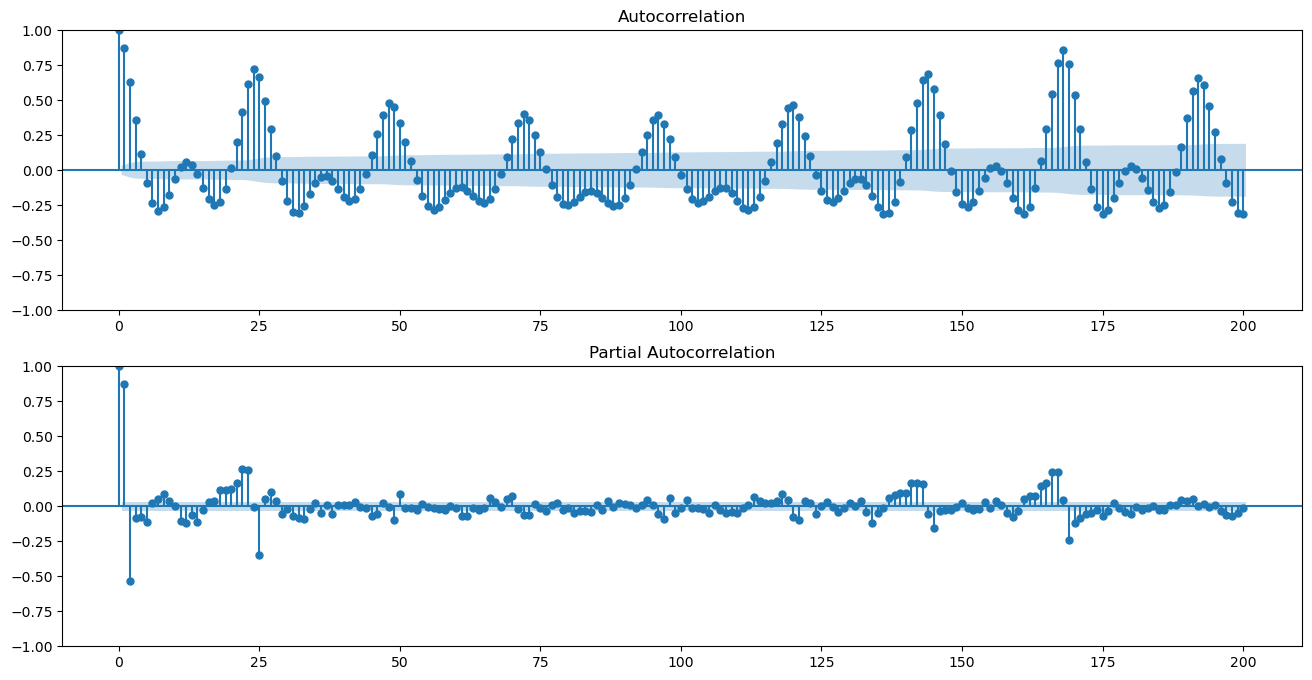

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(dfs[1]['Count'], lags=200, ax=ax[0])
plot_pacf(dfs[1]['Count'], lags=200, ax=ax[1])
plt.show()

### PEAK TIME DETECTION

2017-01-31 ; Weekday :  True


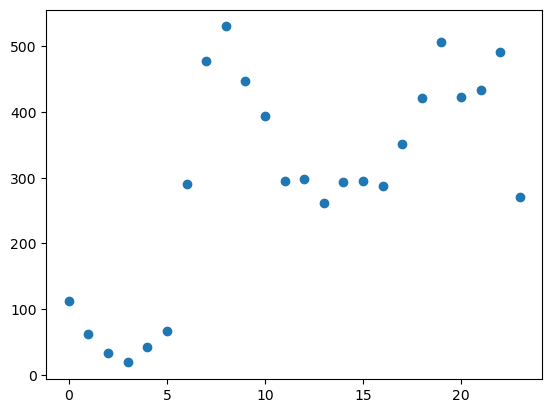

2017-02-01 ; Weekday :  True


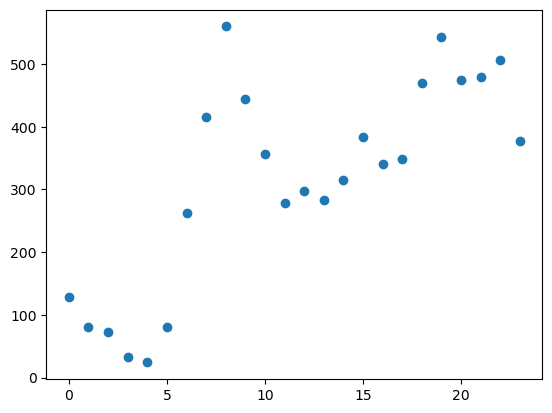

2017-02-02 ; Weekday :  True


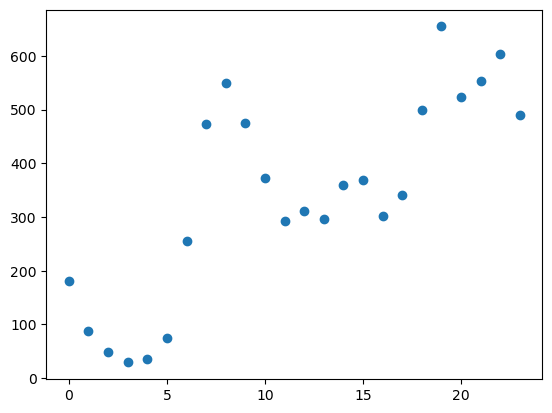

2017-02-03 ; Weekday :  True


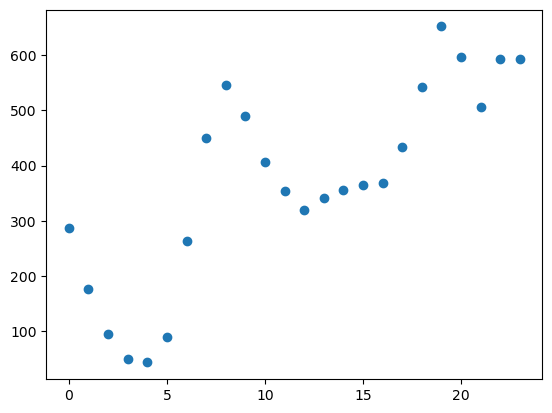

2017-02-04 ; Weekday :  False


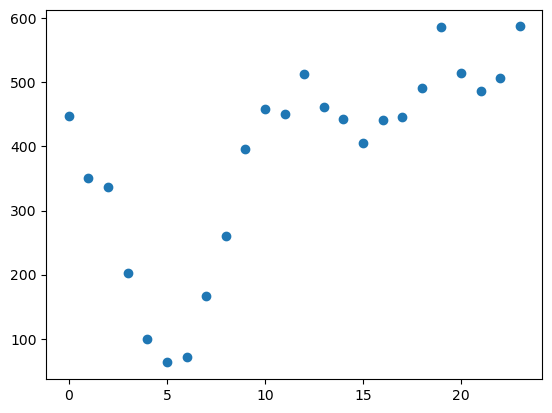

2017-02-05 ; Weekday :  False


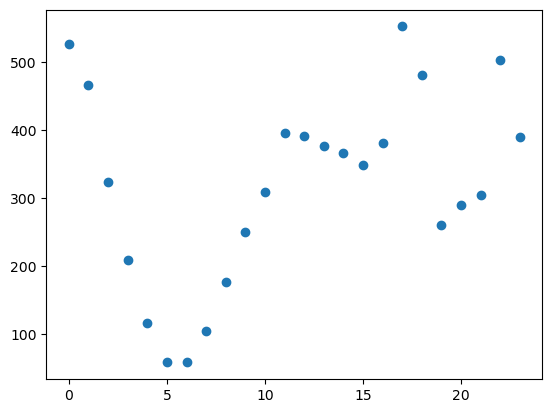

2017-02-06 ; Weekday :  True


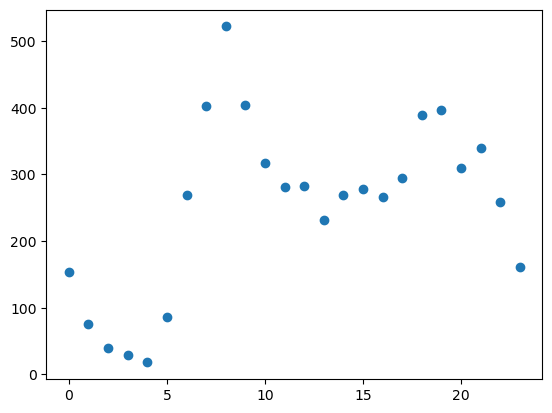

2017-02-07 ; Weekday :  True


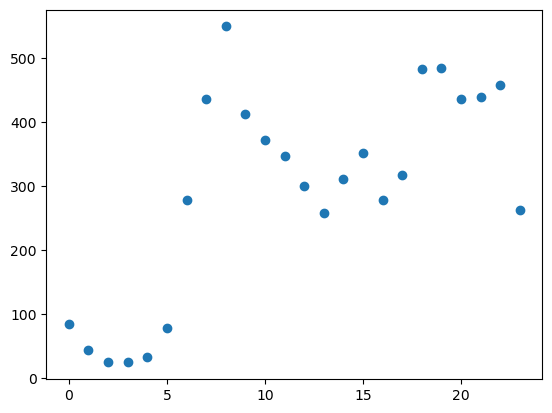

2017-02-08 ; Weekday :  True


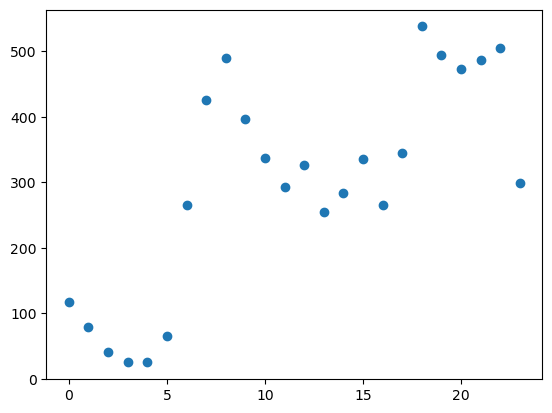

2017-02-09 ; Weekday :  True


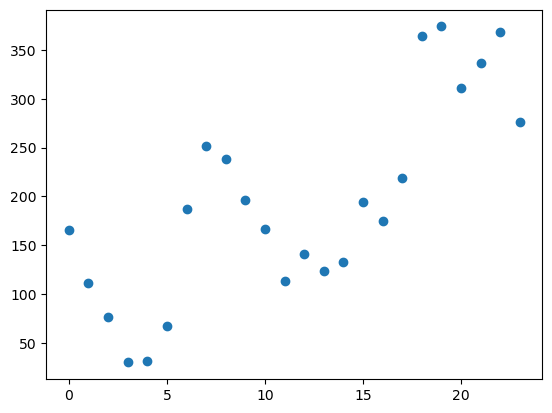

2017-02-10 ; Weekday :  True


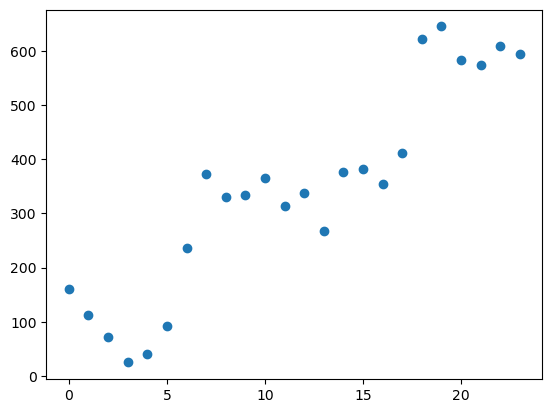

2017-02-11 ; Weekday :  False


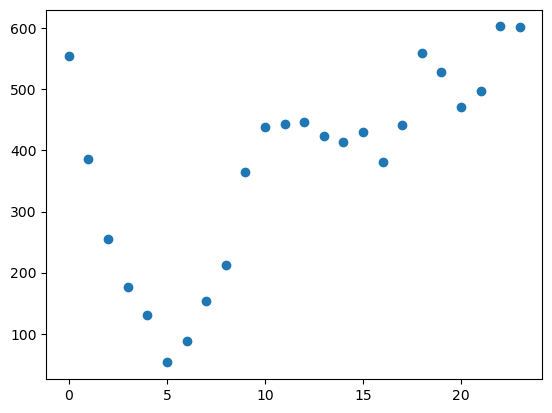

2017-02-12 ; Weekday :  False


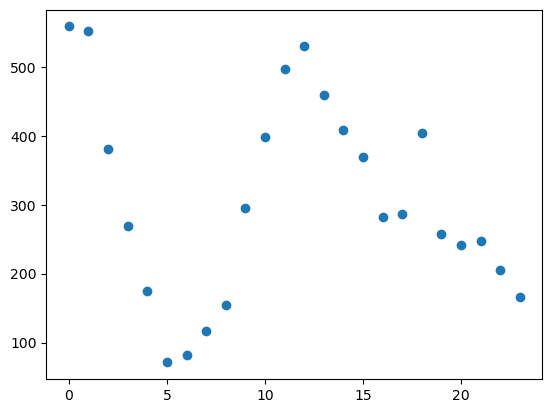

2017-02-13 ; Weekday :  True


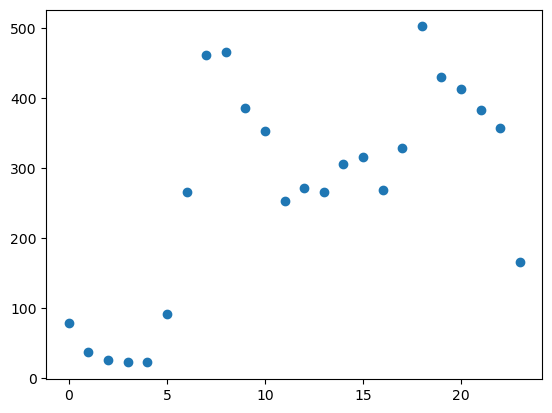

In [10]:
import matplotlib.pyplot as plt
num = 0

dfs[1]['PUTime'] = pd.to_datetime(dfs[1]['PUTime'])
dfs[1]['date'] = dfs[1]['PUTime'].dt.date

for i in range(14):
    zone_zero = dfs[1]
    one_date = zone_zero.iloc[i*24 + (24*30)]['date']
    day_of_week = zone_zero.iloc[i*24 + (24*30)]['PUTime'].dayofweek < 5
    print(one_date, "; Weekday : ", day_of_week)
    zone_zero = zone_zero[ ( zone_zero['date']  == one_date ) ]
    zone_zero["Time"] = zone_zero["PUTime"].dt.hour
   
    
    plt.scatter(zone_zero['Time'], zone_zero['Count'])
    plt.show() # Depending on whether you use IPython or interactive mode, etc.
    
#     plt.savefig("zone_zero_" + str(one_date) + "_" + str(day_of_week) + ".png")
    num = num + 1

**Weekday Peak Time**  :

1. 6-10     

2. 16-20

**Weekend Peak Time**  : 

1. 16-20

### Weather Data

Missing data has been replaced with 0.

In [23]:
weather = pd.read_csv('data/weather.csv')
weather_columns = ['date', 'avg_wind_speed', 'peak_gust_time', 'precipitation', 'snow', 'snow_depth', 'temp_avg', 'temp_max', 'temp_min', 'tot_sunshine',
                  'dir_fwind_2min', 'dir_fwind_5min', 'speed_fwind_2min', 'speed_fwind_5min', 'fog', 'heavy_fog', 'thunder', 'ice_pellets', 'hail', 'glaze', 'smoke']
weather.columns = weather_columns        
weather['date'] = pd.DatetimeIndex(weather['date']).date
weather = weather.dropna(how='all')
weather = weather.drop(['peak_gust_time', 'temp_avg', 'tot_sunshine', 'thunder', 'ice_pellets', 'hail', 'glaze'], 1)
### replace with 0
weather['fog'] = weather['fog'].fillna(0)
weather['smoke'] = weather['smoke'].fillna(0)
weather['heavy_fog'] = weather['heavy_fog'].fillna(0)
weather['dir_fwind_5min'] = weather['dir_fwind_5min'].interpolate(method='polynomial', order=2).fillna(0)
weather['speed_fwind_5min'] = weather['speed_fwind_5min'].interpolate(method='polynomial', order=2).fillna(0)

In [24]:
weather_data = weather.copy()

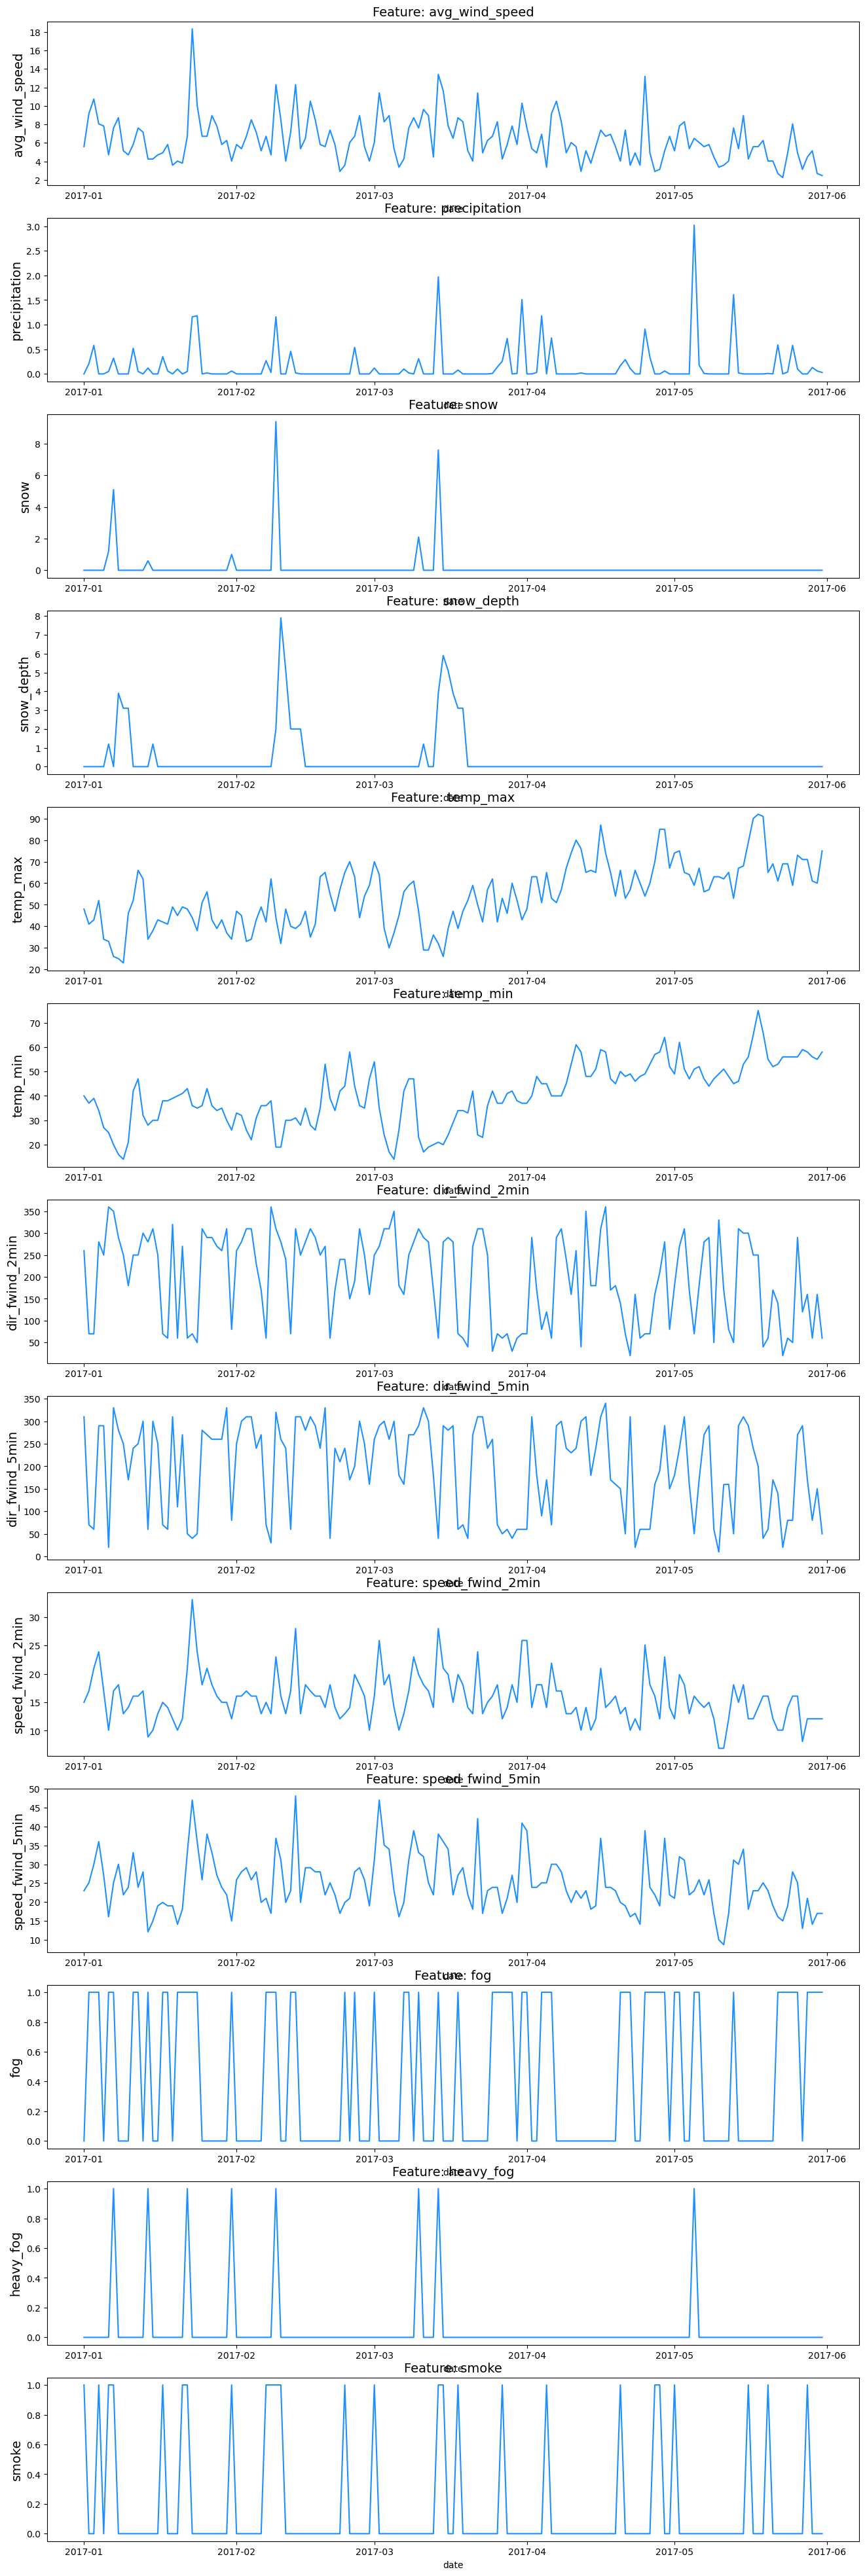

In [26]:
# To compelte the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=13, ncols=1, figsize=(16, 50))

for i, column in enumerate(weather_data.drop('date', axis=1).columns):
#     print(column)
    sns.lineplot(x=weather_data['date'], y=weather_data[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)

### Seasonal Decompose

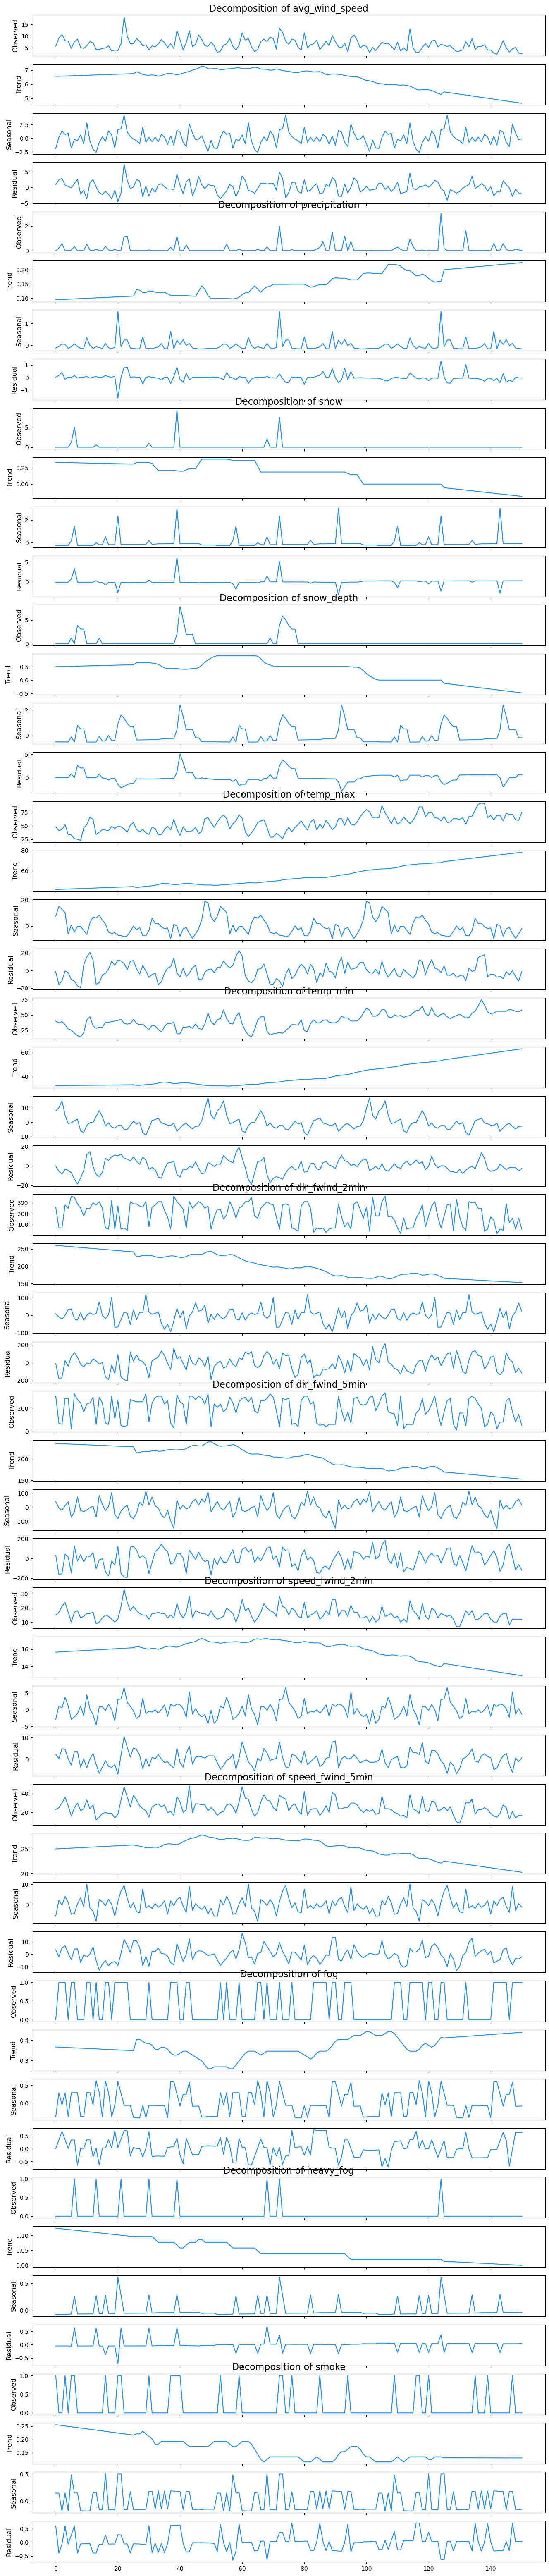

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'avg_wind_speed', 'precipitation', 'snow', 'snow_depth',
    'temp_max', 'temp_min', 'dir_fwind_2min', 'dir_fwind_5min',
    'speed_fwind_2min', 'speed_fwind_5min', 'fog', 
    'heavy_fog', 'smoke'
]

for column in core_columns:
    decomp = seasonal_decompose(weather_data[column], period=52, model='additive', extrapolate_trend='freq')
    weather_data[f"{column}_trend"] = decomp.trend
    weather_data[f"{column}_seasonal"] = decomp.seasonal
fig, ax = plt.subplots(ncols=1, nrows=4*len(core_columns), sharex=True, figsize=(16,80))
row_no = 0
for i, column in enumerate(core_columns):
    
    res = seasonal_decompose(weather_data[column], period=52, model='additive', extrapolate_trend='freq')

    ax[row_no].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[row_no], legend=False, color='dodgerblue')
    ax[row_no].set_ylabel('Observed', fontsize=12)
    row_no = row_no + 1

    res.trend.plot(ax=ax[row_no], legend=False, color='dodgerblue')
    ax[row_no].set_ylabel('Trend', fontsize=12)
    row_no = row_no + 1

    res.seasonal.plot(ax=ax[row_no], legend=False, color='dodgerblue')
    ax[row_no].set_ylabel('Seasonal', fontsize=12)
    row_no = row_no + 1
    
    res.resid.plot(ax=ax[row_no], legend=False, color='dodgerblue')
    ax[row_no].set_ylabel('Residual', fontsize=12)
    row_no = row_no + 1

plt.show()

### Correlation of Weather Features

Text(0.5, 1.0, 'Correlation Matrix of Core Features')

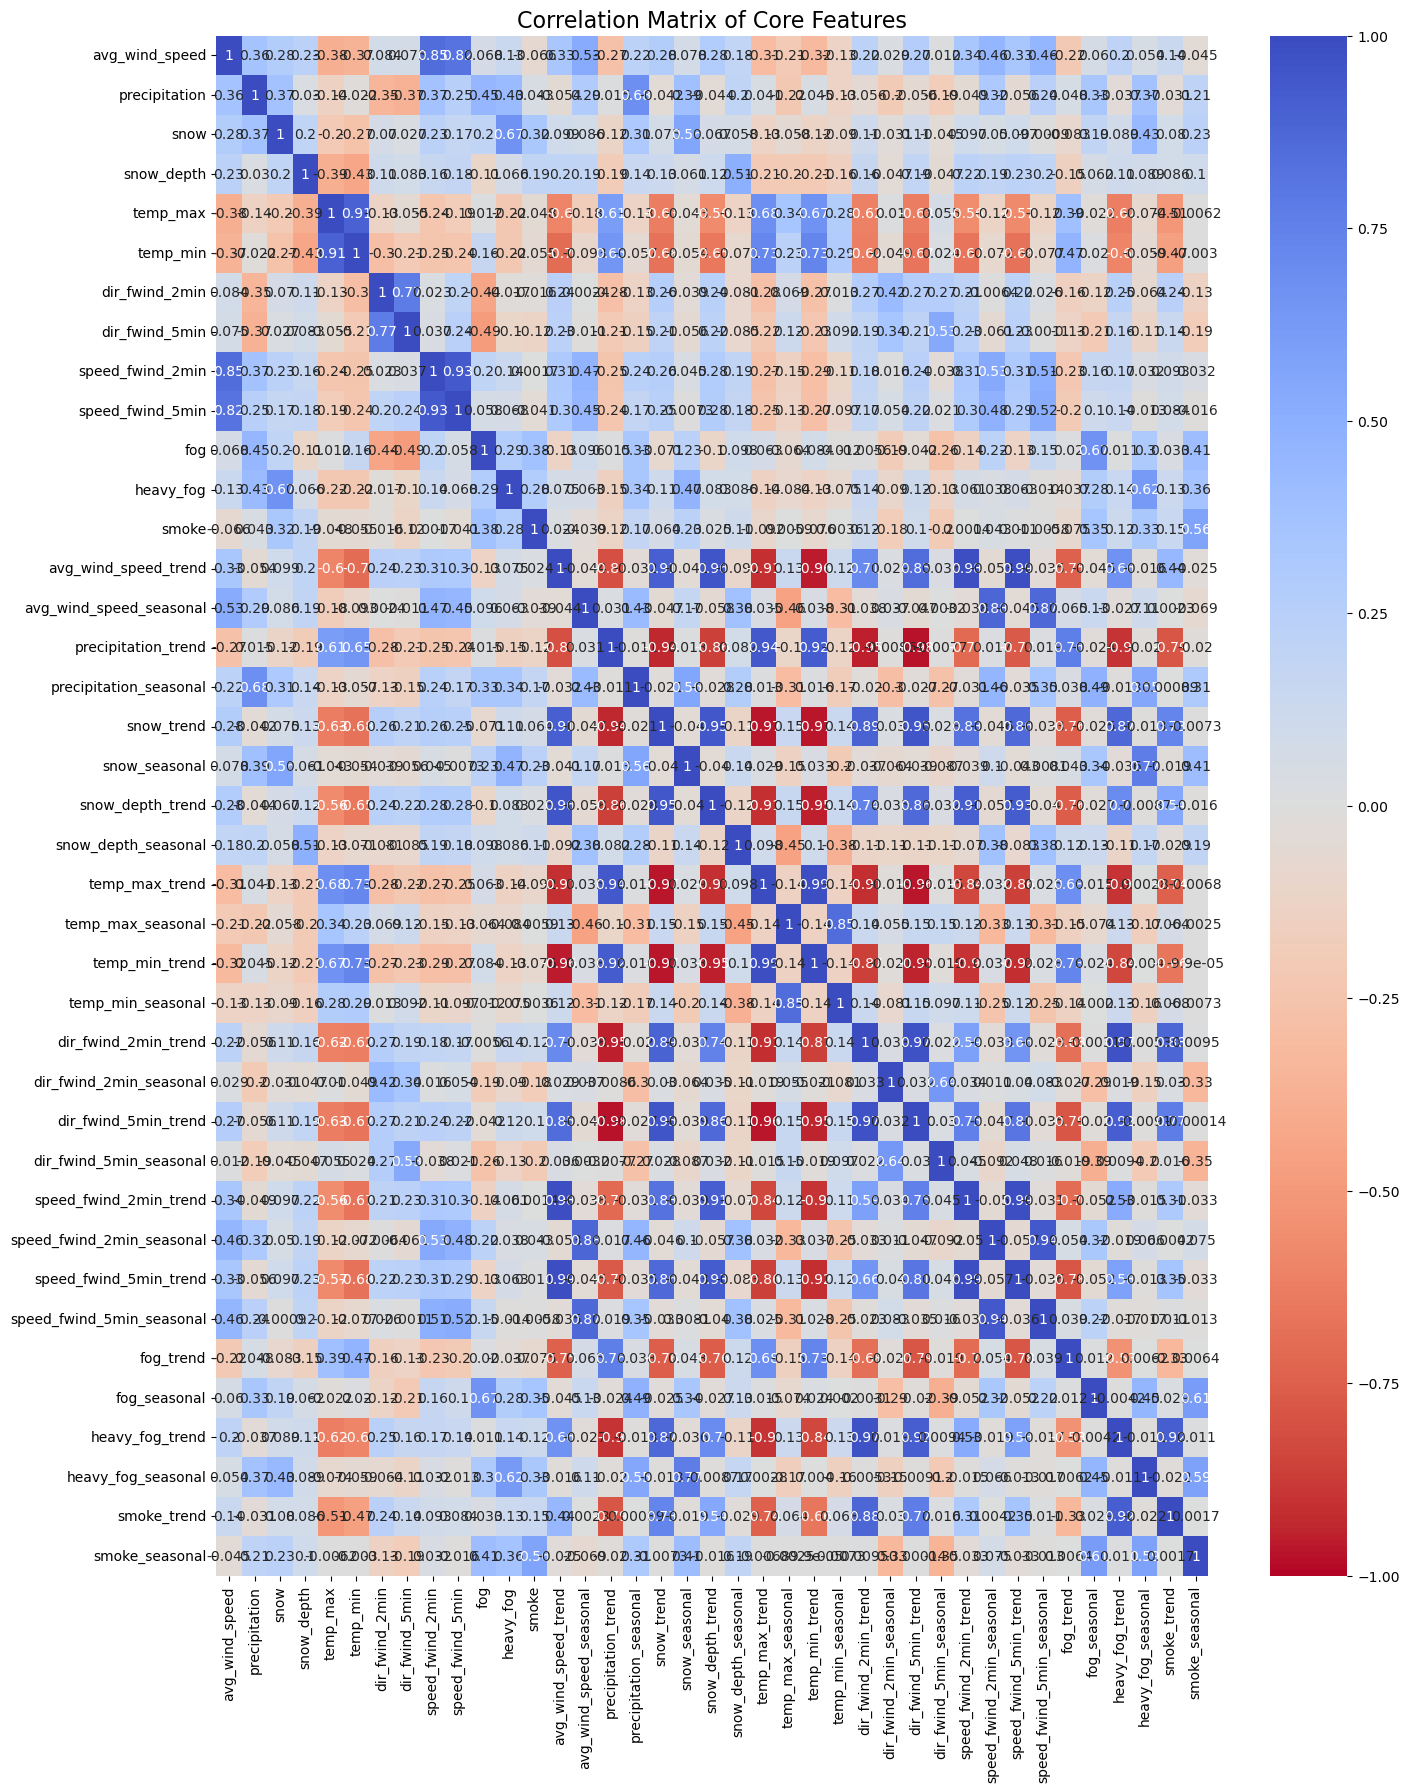

In [31]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 20))

corrmat = weather_data.corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax)
ax.set_title('Correlation Matrix of Core Features', fontsize=16)

### Correlation of Lagging Weather Features with Trip Count

In [32]:
df = pd.concat(map(pd.read_csv, ['data/2017-01_1H_zone.csv', 'data/2017-02_1H_zone.csv','data/2017-03_1H_zone.csv',
                                'data/2017-04_1H_zone.csv','data/2017-05_1H_zone.csv']))
df.drop(['Unnamed: 0'], axis=1,inplace=True)
df['PUTime'] = pd.to_datetime(df['PUTime'])
df['date'] = df['PUTime'].dt.date
df['hour'] = df['PUTime'].dt.hour

avg_wind_speed


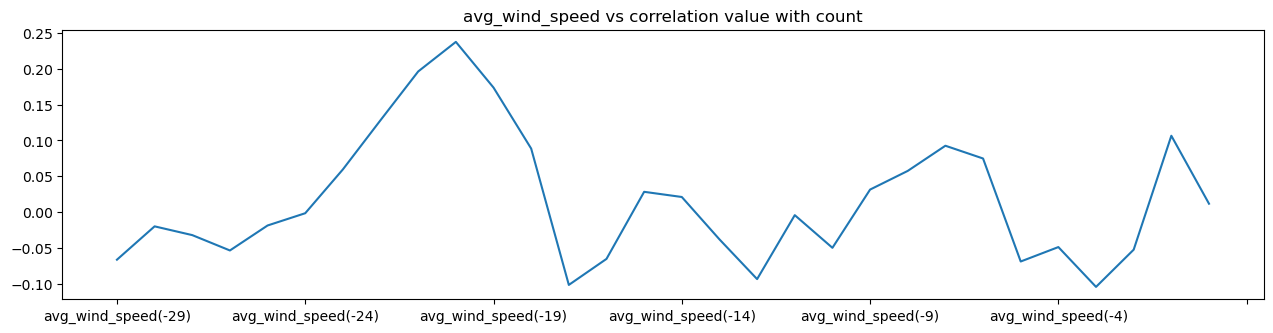

precipitation


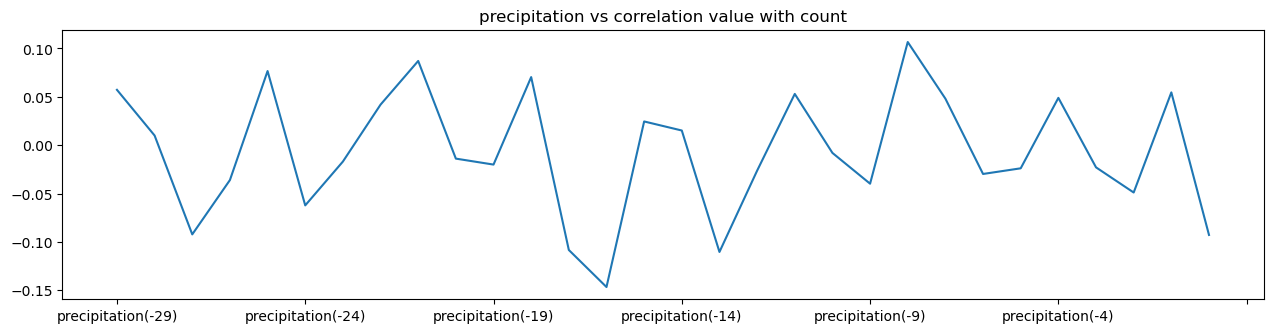

snow


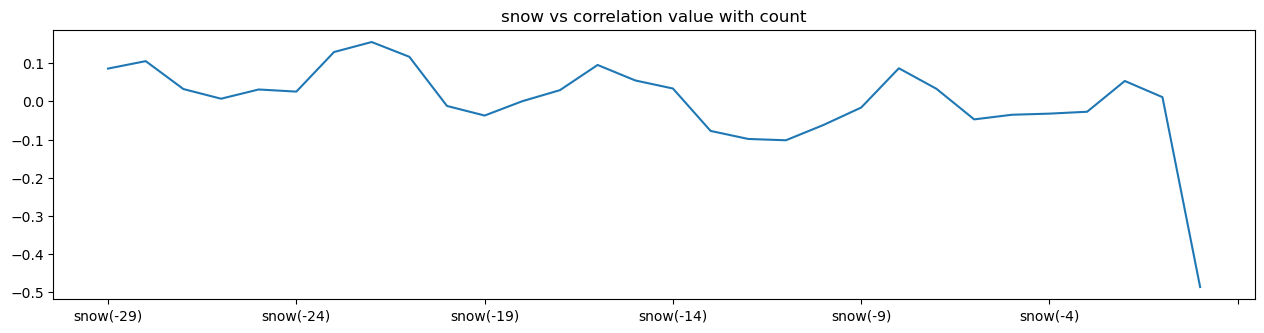

snow_depth


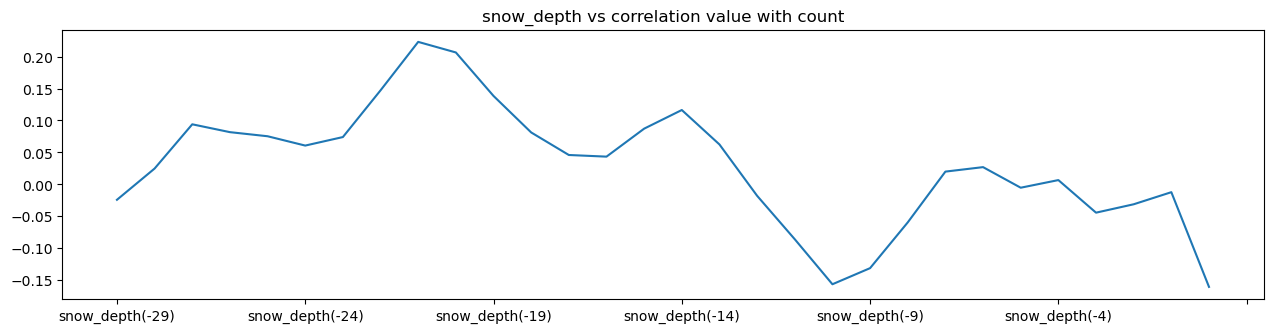

temp_max


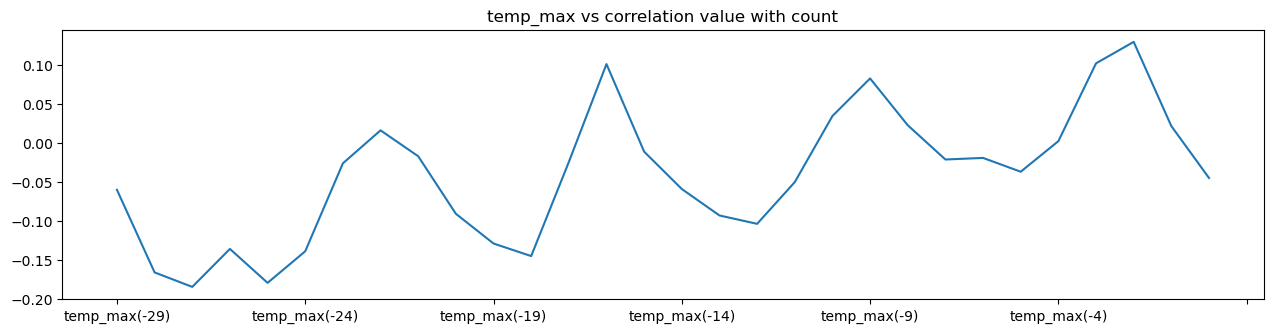

temp_min


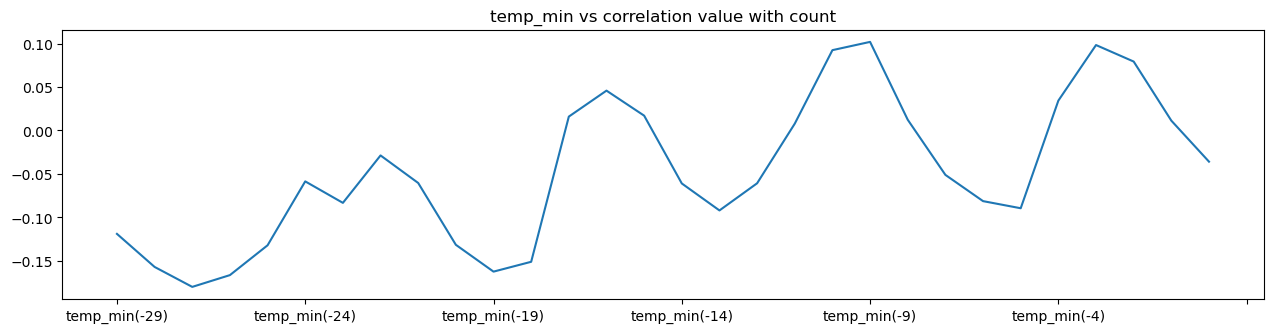

dir_fwind_2min


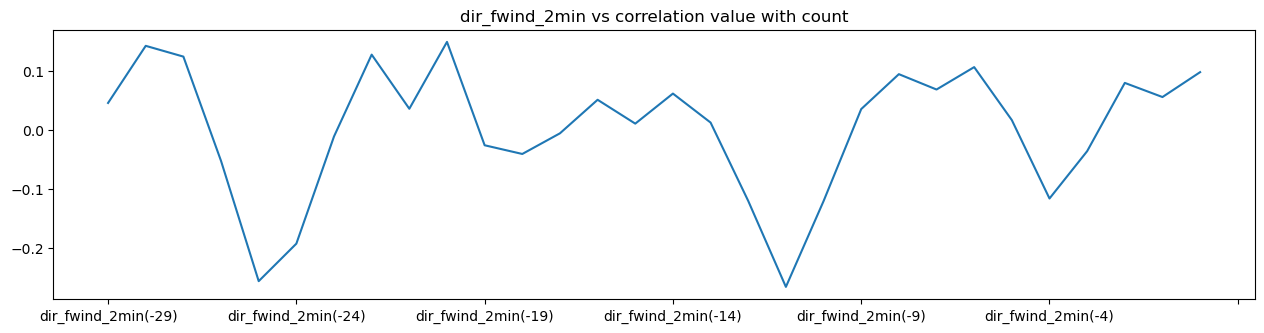

dir_fwind_5min


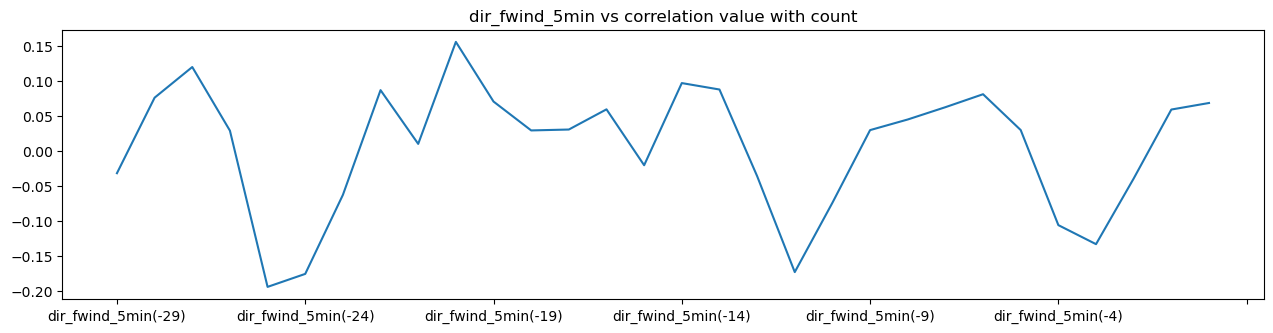

speed_fwind_2min


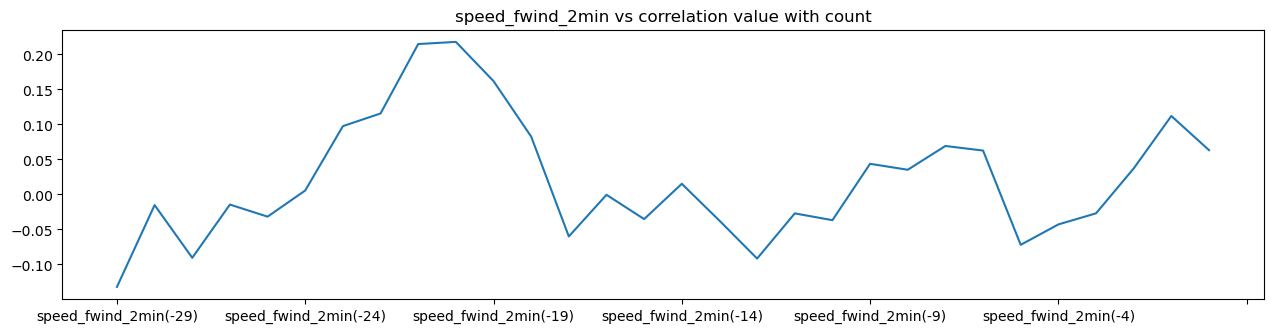

speed_fwind_5min


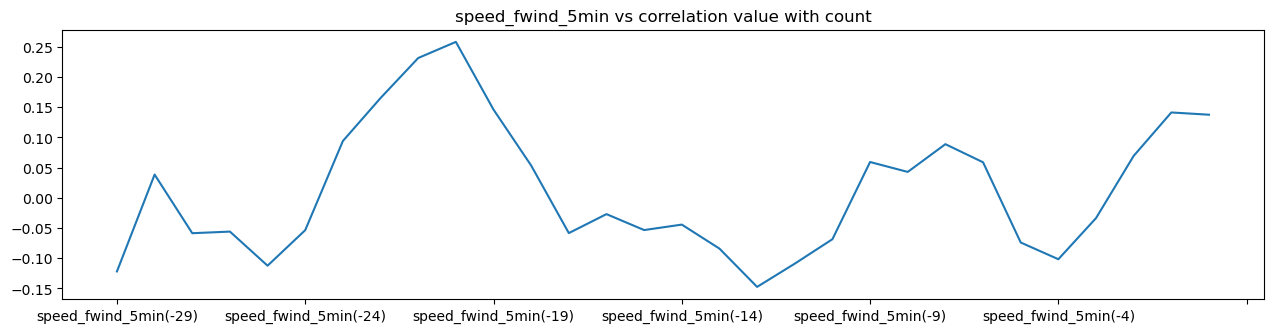

fog


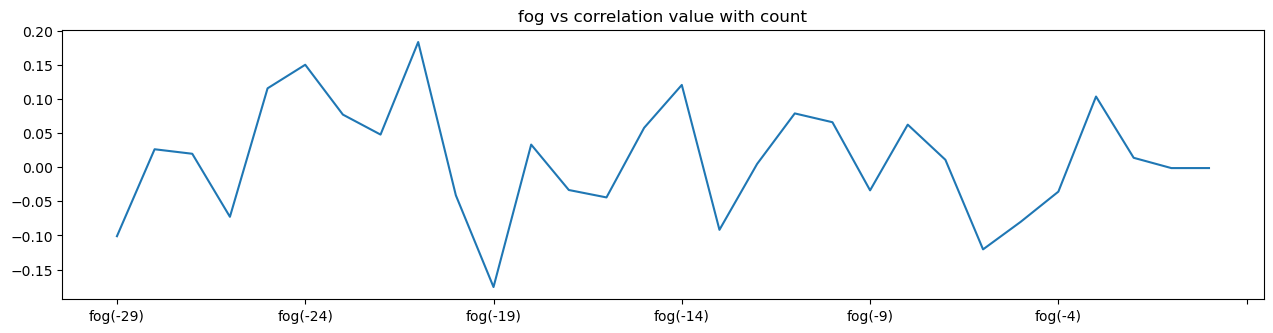

heavy_fog


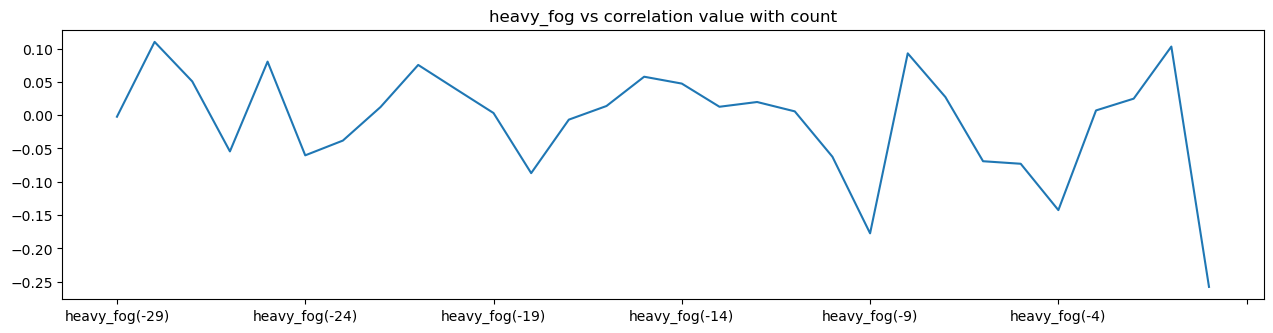

smoke


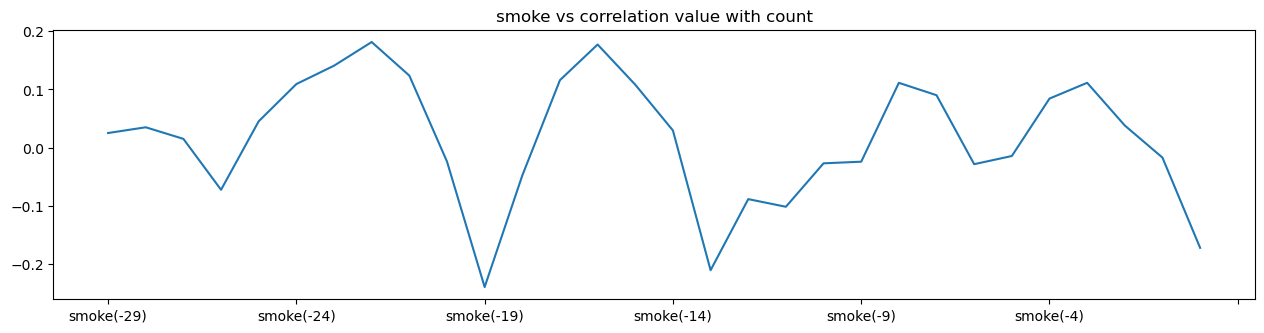

In [33]:
df['date'] = df['date'].astype(str)
weather['date'] = weather['date'].astype(str)
dfw = df.merge(weather, on='date')
keep_columns = ['Count','hour','date',
       'avg_wind_speed', 'precipitation', 'snow', 'snow_depth', 'temp_max',
       'temp_min', 'dir_fwind_2min', 'dir_fwind_5min', 'speed_fwind_2min',
       'speed_fwind_5min', 'fog', 'heavy_fog', 'smoke','PUZone']

dfAll3 = dfw.filter(keep_columns)
dfw_z = dfAll3.groupby(["date"]).mean()
for weather_param in dfw_z.columns.to_list():
    indexed_df = dfw_z.copy()
    indexed_df = indexed_df.filter([weather_param],axis=1)
    n_steps_in = 30
    dfw_z_new = pd.DataFrame()
    for k in range(len(indexed_df.columns)) :
        for i in range(n_steps_in):
            dfw_z_new[indexed_df.columns[k] + '(' + str(-i) + ')'] = indexed_df.iloc[:,k].shift(i)
    #             if i<=4 :
    #                 X_new[indexed_df.columns[k] + '(' + str(-24*7*i) + ')'] = indexed_df.iloc[:,k].shift(24*7*i)
    dfw_z_new = dfw_z_new.iloc[:, ::-1]
    dfw_z_new['Count'] = dfw_z['Count'].values
    dfw_z_new = dfw_z_new.dropna()
    if weather_param=='Count' or weather_param=='hour' or weather_param=='PUZone' :
        continue
    print(weather_param)
#     print(type(dfw_z_new.corr().iloc[30,:]))
    dfw_z_new.corr().iloc[30,:-1].plot()
    fig = plt.gcf()
    fig.set_size_inches(15.5, 3.5)
    plt.title(weather_param+' vs correlation value with count')
    plt.show()
#     plt.tick_params(axis='x', which='major', labelsize=4)
    plt.clf

## Findings
* There are some noticeable seasonality here
* However, all of the correlation values of weather parameters with today's count are very low
* So we could concur that trip count does not have significant dependency with past month's weather

### Training

In [34]:
weather_columns = ['date', 'avg_wind_speed', 'peak_gust_time', 'precipitation', 'snow', 'snow_depth', 'temp_avg', 'temp_max', 'temp_min', 'tot_sunshine',
                  'dir_fwind_2min', 'dir_fwind_5min', 'speed_fwind_2min', 'speed_fwind_5min', 'fog', 'heavy_fog', 'thunder', 'ice_pellets', 'hail', 'glaze', 'smoke']
traffic_columns = ['PUZone', 'Count', 'PUTime']

In [18]:
from datetime import datetime, timedelta

def datetime_range(end, delta, count):
        
        current = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
        for i in range(count):
            yield current
            current -= delta

In [35]:
from sklearn.model_selection import cross_validate
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print("Cross validation Mean Absolute Error:",mae)

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
class Model():
    
    def __init__(self):
        self.random_forest = RandomForestRegressor(n_estimators=100)
        self.decision_tree = DecisionTreeRegressor()
        self.mlp = MLPRegressor(hidden_layer_sizes=(300,150), max_iter=200,activation ='relu',solver='adam',random_state=1)
        self.xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
        self.lgbm = LGBMRegressor(learning_rate = 0.01, num_iterations = 1000)
        self.svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
#         self.ensemble = VotingRegressor([('lgbm', self.lgbm), ('xgb', self.xgb), ('svr', self.svr)])
        self.ensemble = VotingRegressor([('lgbm', self.lgbm), ('xgb', self.xgb), ('rf', self.random_forest), ('mlp', self.mlp)])
        self.count = 0
        self.to_keep = []
        self.weather_to_keep = []
        self.train_drop_list = ['Count(0)', 'date']
        self.model = self.ensemble
        return 
    
    def train_model(self, traffic, weather):
        df = self.preprocessing(traffic, weather)
        df.to_csv('new_merged.csv', index=False)
        
        train = df.loc[df.date < '2017-05-01']
        valid = df.loc[df.date >= '2017-05-01']
        
        ts_cv = TimeSeriesSplit(
            n_splits=5,
            gap=48,
            max_train_size=10000,
            test_size=1000,
        )
        
        train_y = train['Count(0)']
        
        train_x = train.drop(self.train_drop_list, axis=1)
        self.to_keep = train_x.columns
        
        valid_y = valid['Count(0)']
        valid_x = valid.drop(self.train_drop_list, axis=1)        
        
        self.model.fit(train_x,train_y)
        pred_y = self.model.predict(valid_x)
        valid_y_array = valid_y.values.ravel()
        mae = mean_absolute_error(valid_y_array,pred_y)
        print('Validation MAE: ', mae)
        
        evaluate(self.model, df.drop(self.train_drop_list, axis=1), df['Count(0)'], cv=ts_cv)
    
    
    
    def preprocessing(self, traffic, weather):
        
        # extract date and hour
        
        traffic['PUTime'] = pd.to_datetime(traffic['PUTime'])
        traffic['date'] = traffic['PUTime'].dt.date
        traffic['hour'] = traffic['PUTime'].dt.hour
        traffic['weekday'] = (traffic['PUTime'].dt.dayofweek < 5).astype(int)
        
        traffic['peak_hour'] = (traffic['hour'] >= 16) * (traffic['hour'] <= 20) + (traffic['weekday'] == 1) * (traffic['hour'] >= 6) * (traffic['hour'] <= 10) 
        traffic['peak_hour'] = traffic['peak_hour'].astype(int)
        
        # group by zones
        grouped = traffic.groupby(traffic.PUZone)
        dfs = []
        for i in range(0,73):
            dfs.append(grouped.get_group(i))
        
        for zone in range(0,73) :
            dfs[zone].drop(['PUZone'], axis=1,inplace=True)
            
        # Preprocess weather
        weather.columns = weather_columns

        weather['date'] = pd.DatetimeIndex(weather['date']).date
        
        # handle null values
        weather = weather.dropna(how='all')
        weather = weather.drop(['peak_gust_time', 'temp_avg', 'tot_sunshine', 'thunder', 'ice_pellets', 'hail', 'glaze'], 1)
        
        ### replace with 0
        for col in weather.columns:
            weather[col] = weather[col].fillna(0)
                                
        weather = weather[['date']+self.weather_to_keep]
        
        X2 = []
        # add same hour for previous 30 days
        for zone in range(0,73) :
            dfs[zone]["PUTime"] = pd.to_datetime(dfs[zone]["PUTime"]) # Convert column type to be datetime
            indexed_df = dfs[zone].set_index(["PUTime"])           # Create a datetime index
            indexed_df.drop(['date'],axis=1,inplace=True)
            indexed_df.drop(['hour'],axis=1,inplace=True)
            indexed_df.drop(['weekday'], axis=1, inplace=True)
            indexed_df.drop(['peak_hour'], axis=1, inplace=True)
            
            
            n_steps_in = 30
            X_new = pd.DataFrame()
            for k in range(len(indexed_df.columns)) :
                for i in range(0, n_steps_in+1):
                    X_new[indexed_df.columns[k] + '(' + str(-24*i) + ')'] = indexed_df.iloc[:,k].shift(24*i)
                    if i<=24 :
                        X_new[indexed_df.columns[k] + '(' + str(-i) + ')'] = indexed_df.iloc[:,k].shift(i)
            X_new = X_new.iloc[:, ::-1]
            X_new['date'] = dfs[zone]['date'].values
            X_new['hour'] = dfs[zone]['hour'].values
            X_new['weekday'] = dfs[zone]['weekday'].values
            X_new['peak_hour'] = dfs[zone]['peak_hour'].values
            
            X2.append(X_new)
            
            
        for zone in range(0,73):
            X2[zone] = X2[zone].dropna()
            
        dfW2 = []
        for zone in range(0,73):
            X2[zone]['date'] = X2[zone]['date'].astype(str)
            weather['date'] = weather['date'].astype(str)
            dfW2.append(X2[zone].merge(weather, on='date'))
        
        
        for zone in range(0,73):
            dfW2[zone]['PUZone'] = zone
            
        
        dfAll2 = pd.concat(dfW2, axis=0)
        return dfAll2


    def preprocess_test(self, demand, weather, dt, neighbour):
        
        df = pd.DataFrame(columns=self.to_keep)
        df['PUZone'] = [i for i in range(0, 73)]
        
        pred_date_time_obj = datetime.strptime(dt, '%Y-%m-%d %H:%M:%S')
        pred_date, pred_time = dt.split(" ")
        df['weekday'] = (pred_date_time_obj.weekday() < 5)
        df['weekday'] = df['weekday'].astype(int)
        df['hour'] = pred_date_time_obj.hour
        
        df['peak_hour'] = (df['hour'] >= 16) * (df['hour'] <= 20) + (df['weekday'] == 1) * (df['hour'] >= 6) * (df['hour'] <= 10)
        df['peak_hour'] = df['peak_hour'].astype(int)
        
        
        for i in range(1, 25):
            df['Count('+str(-i)+')'] = demand[-i]
        for i in range(1, 31):
            df['Count('+str(-i*24)+')'] = demand[-i*24]
        
        w = weather[-1]
        for i in range(len(weather_columns)):
            if weather_columns[i] in self.to_keep:
                df[weather_columns[i]] = [w[i]] * 73
                df[weather_columns[i]] = df[weather_columns[i]].interpolate()
        
        
        # fill nulls
        df = df.fillna(0)
        return df
    

    def predict(self, demand, weather, dt, neighbors):
        '''
        Parameters
        ----------
        demand: (24*30, 73) numpy array containing last 30 days' hourly demand data, e.g. demand[-1, 3] contains last hour's demand of zone 3
        weather: List of lists containing today's and last 30 days' weather data, e.g., weather[-1] is a list containing today's weather data with [DATE, AWND,...,WT08] as in weather.csv
        dt: date and time of the prediction e.g., "2017-06-01 00:00:00"
        neighbors - Dictionary containing the mapping between each zone and their list of neighbors in zone_neighbors.json

        Return
        ------
        predictions: List of 73 non-negative integers - your trip forecast for each zone in the next hour
        '''
        
        df = self.preprocess_test(demand, weather, dt, neighbors)
        pred_y = self.model.predict(df)
        
        self.count += 1
        if self.count % 100 == 0:
            print(self.count, ' times done.')
        
        return pred_y

In [37]:
traffic = pd.concat(map(pd.read_csv, ['data/2017-01_1H_zone.csv', 'data/2017-02_1H_zone.csv', 
                                     'data/2017-03_1H_zone.csv', 'data/2017-04_1H_zone.csv', 'data/2017-05_1H_zone.csv']))
traffic.drop(['Unnamed: 0'], axis=1,inplace=True)
        
weather = pd.read_csv('data/weather.csv')

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import test_pred
model = Model()
model.train_model(traffic, weather)

In [24]:
mae, zone_mae = test_pred.eval(model)

100  times done.
200  times done.
300  times done.
400  times done.
500  times done.
600  times done.
700  times done.


In [25]:
print(mae)

15.0355195314614


In [26]:
print(zone_mae)

[23.05596545 24.34701023 17.10621042 17.13374094  4.01125255  0.65798361
  2.53153662  0.42841255 10.20360194  0.98954141 12.82380894  0.38447607
 15.29215851 17.62301343 21.45813551 34.32231629 12.93817258 14.88589215
  3.37544254 17.68774711 10.94135712  3.62553383 16.87639347  0.7052762
 43.40953659 35.55324364 30.00933262 24.00573232 10.41570787  1.34077885
 30.7041906  44.81741714  0.64641602  4.86581458 11.93946685  6.15196966
 18.67546274 35.44947076 19.90789222  4.41067179 17.86487458 29.74778507
  0.54439182 37.73053082 39.30936139 22.98790758 26.89422618  6.10781811
  1.39075046  3.75697775 21.62612218  1.40595413 22.96006932  9.41327681
 15.10130849 18.03541367  2.77452336  4.96061811  8.41791271  4.94707328
 27.53347813  4.81348089 33.78405511 14.64171546  1.83137981 24.60998941
  0.65625258  9.16804171 11.23262242 28.79240089 10.76390591  7.61283993
 20.46778397]
